In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.models import load_model
from keras.preprocessing import image
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
import csv

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_csv='/kaggle/input/dataset/dataset.csv'
data1_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
data2_dir = '/kaggle/input/deepfake-and-real-images/Dataset'
data3_dir = '/kaggle/input/hardfakevsrealfaces'
data4_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face'
data5_dir = '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset'

In [3]:
os.listdir(data5_dir)

['validate', 'test', 'train']

In [4]:
img = cv2.imread(os.path.join(data2_dir,'Train','Real','real_58276.jpg'))

In [5]:
type(img)

numpy.ndarray

In [6]:
img.shape

(256, 256, 3)

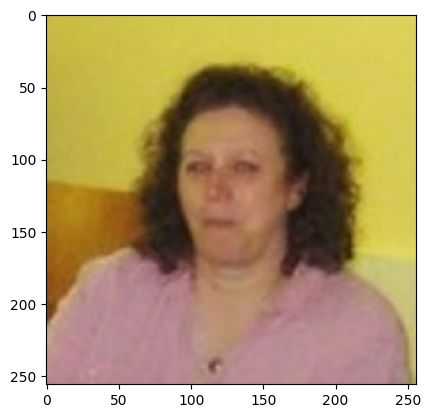

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
data_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 140002 files belonging to 2 classes.


Dataset 1 (140k Real vs Fake) → Total images: 140000


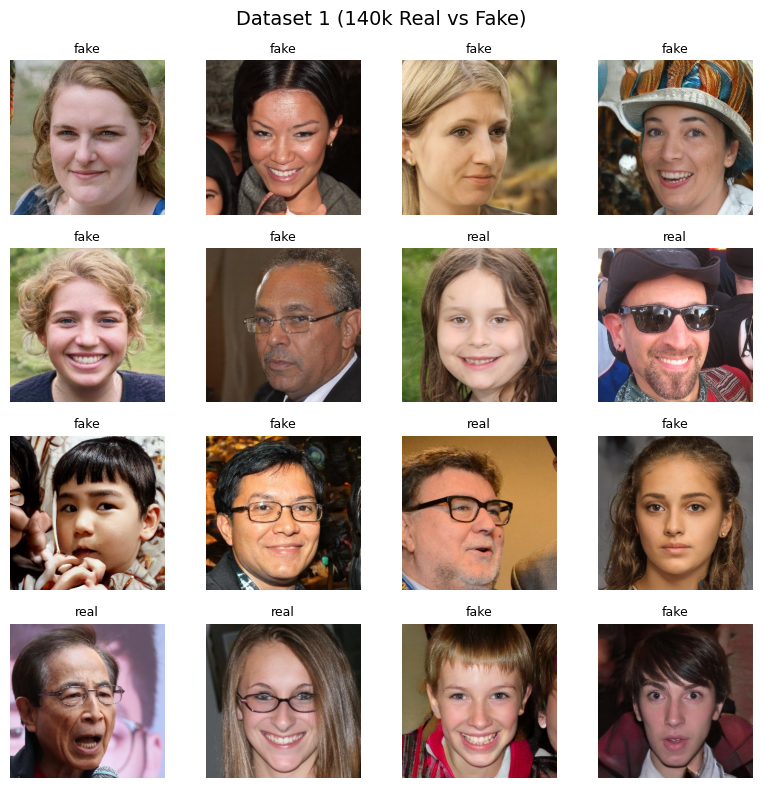

Dataset 2 (Deepfake & Real) → Total images: 190335


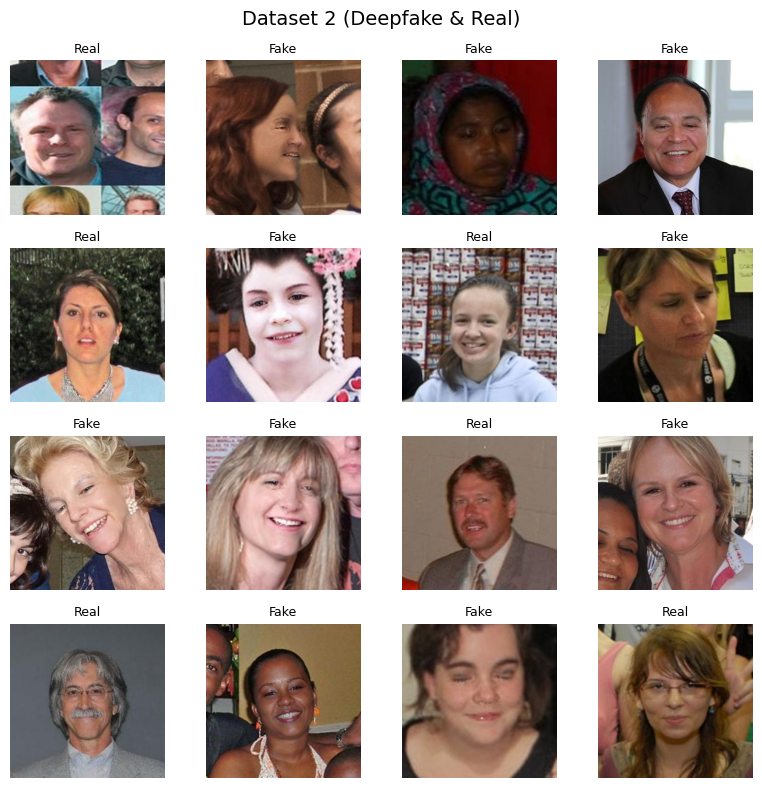

Dataset 3 (HardFake vs Real) → Total images: 1289


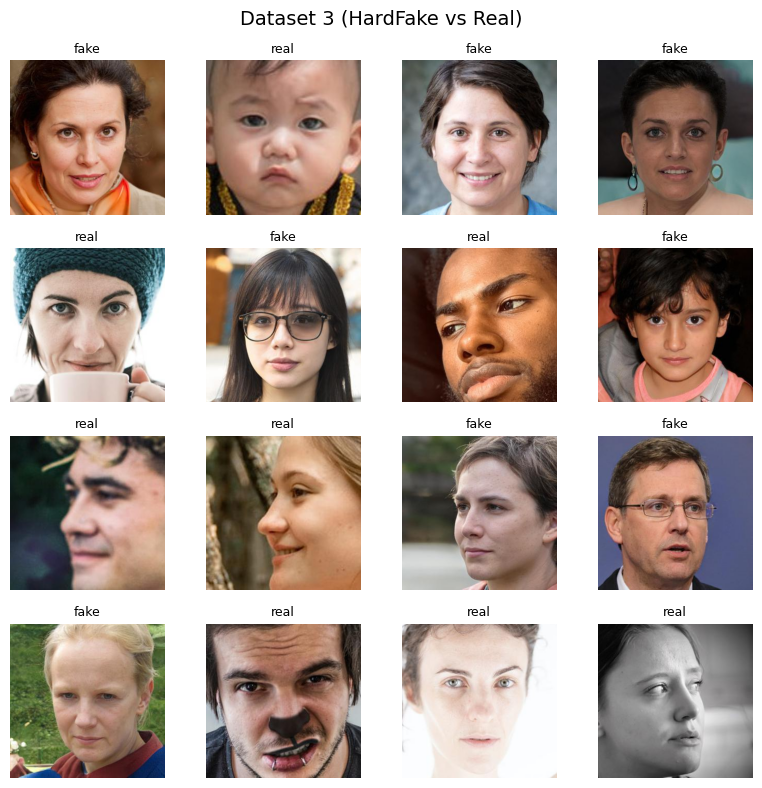

Dataset 4 (Real & Fake Face Detection) → Total images: 2041


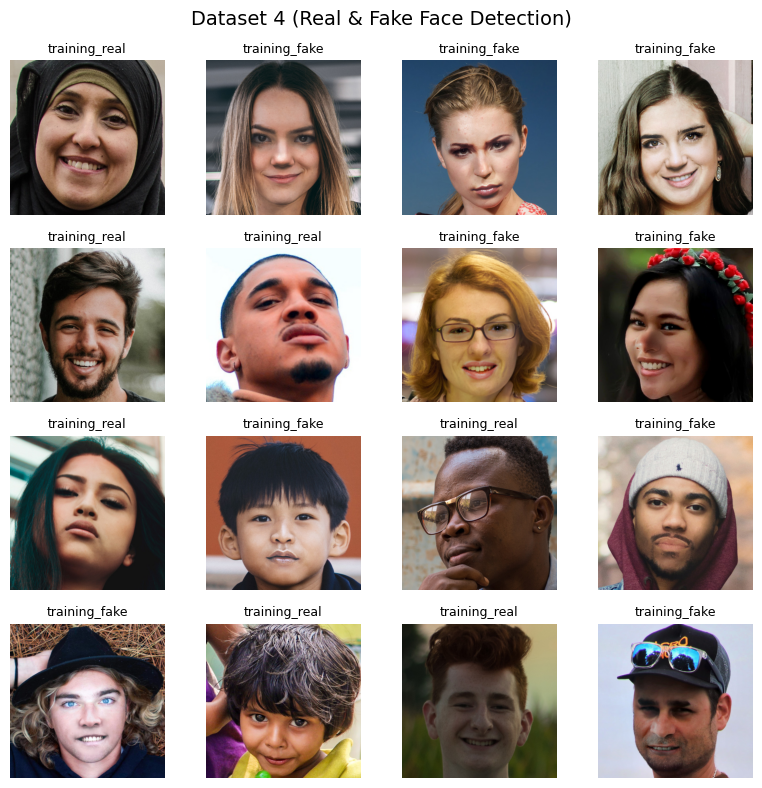

Dataset 5 (AI vs Real Faces) → Total images: 120954


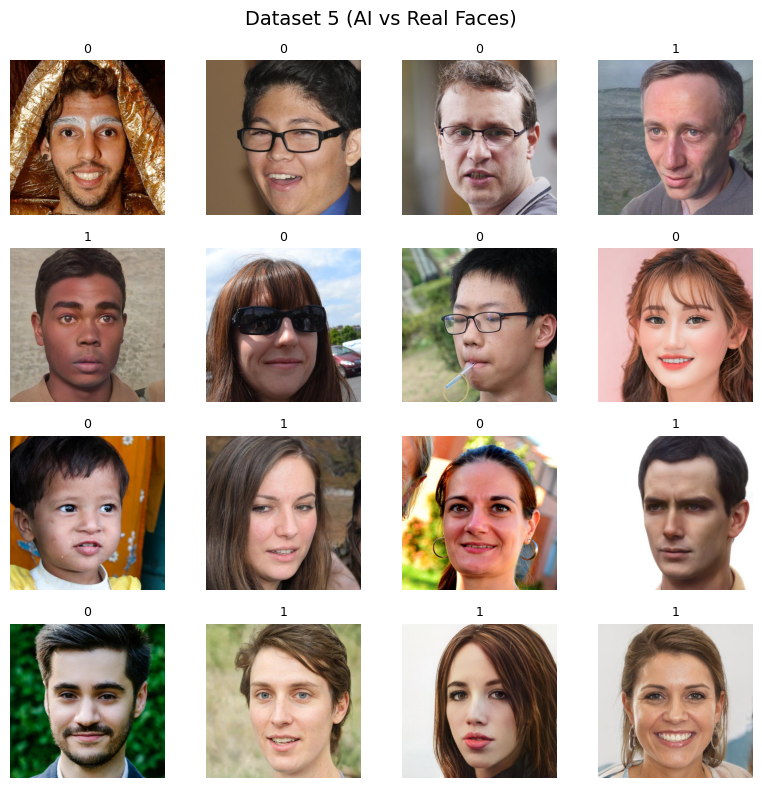

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def get_all_images_with_labels(root_dir, exts=(".jpg", ".jpeg", ".png")):
    data = []
    for root, _, files in os.walk(root_dir):
        label = os.path.basename(root)   
        for file in files:
            if file.lower().endswith(exts):
                img_path = os.path.join(root, file)
                data.append((img_path, label))
    return data


def show_random_samples(data, title, n=16):
    samples = random.sample(data, min(n, len(data)))

    plt.figure(figsize=(8, 8))
    for i, (img_path, label) in enumerate(samples):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=9) 
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


datasets = {
    "Dataset 1 (140k Real vs Fake)": "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake",
    "Dataset 2 (Deepfake & Real)": "/kaggle/input/deepfake-and-real-images/Dataset",
    "Dataset 3 (HardFake vs Real)": "/kaggle/input/hardfakevsrealfaces",
    "Dataset 4 (Real & Fake Face Detection)": "/kaggle/input/real-and-fake-face-detection/real_and_fake_face",
    "Dataset 5 (AI vs Real Faces)": "/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset",
}

for name, path in datasets.items():
    data = get_all_images_with_labels(path)
    print(f"{name} → Total images: {len(data)}")

    if len(data) > 0:
        show_random_samples(data, name)
    else:
        print(" No images found\n")


# **creating csv file contains the compination of multiple datasets**

In [10]:
if os.path.exists(data_csv):
    print('exists')
else:
       
    data_dirs = [ data5_dir, data4_dir]

    # Define the path for the CSV file
    csv_file = 'dataset1.csv'
    data_csv=csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0':'Real',
        '1':'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])


In [11]:
target_size = (224, 224)

In [12]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Load the CSV file into a DataFrame
df = pd.read_csv(data_csv)

# Create an ImageDataGenerator instance with rescaling and other desired preprocessing options
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split the data into train/validation sets
)

In [13]:
# Create a data generator from the DataFrame using flow_from_dataframe()
data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',         # Column containing the image paths
    y_col='label',         # Column containing the labels
    target_size=target_size,
    batch_size=32,
    class_mode='binary',  # Use 'categorical' for multi-class classification
    shuffle=True,           # Shuffle the data
    seed=42,                # Set random seed for reproducibility
    subset='training'       # Use 'training' subset for training data
)

Found 98396 validated image filenames belonging to 2 classes.


In [14]:
# Create a validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset='validation'  # Use 'validation' subset for validation data
)

Found 24599 validated image filenames belonging to 2 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

input_layer = Input(shape=(target_size[0], target_size[1], 3))


base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=input_layer
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# # Learning rate reduction when val_accuracy plateaus
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     patience=8,
#     verbose=1,
#     factor=0.3,
#     min_lr=1e-6
# )

# #  Stop early if validation loss doesn’t improve
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

#  Save the best model (highest val_accuracy)
model_ckpt = ModelCheckpoint(
    "best_pretrained_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

#  Callbacks list
#callbacks = [learning_rate_reduction, early_stop, model_ckpt]
callbacks = [model_ckpt]
#  Fit the model using X_train, y_train instead of generator
epochs = 32
history = model.fit(data_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=50,       # You can adjust this
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=1
                   )

Epoch 1/32
3075/3075 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.5902 - auc: 0.5978
Epoch 1: val_accuracy improved from -inf to 0.61425, saving model to best_pretrained_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3075/3075 [==============================] - 972s 314ms/step - loss: 0.6679 - accuracy: 0.5902 - auc: 0.5978 - val_loss: 0.6431 - val_accuracy: 0.6143 - val_auc: 0.6745
Epoch 2/32
3075/3075 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.6291 - auc: 0.6609
Epoch 2: val_accuracy improved from 0.61425 to 0.64434, saving model to best_pretrained_model.h5
3075/3075 [==============================] - 449s 146ms/step - loss: 0.6430 - accuracy: 0.6291 - auc: 0.6609 - val_loss: 0.6275 - val_accuracy: 0.6443 - val_auc: 0.7047
Epoch 3/32
3075/3075 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.6481 - auc: 0.6858
Epoch 3: val_accuracy improved from 0.64434 to 0.67190, saving model to best_pretrained_model.h5
3075/3075 [==============================] - 405s 132ms/step - loss: 0.6301 - accuracy: 0.6481 - auc: 0.6858 - val_loss: 0.6109 - val_accuracy: 0.6719 - val_auc: 0.7233
Epoch 4/32
3075/3075 [==============================] - ETA: 0s - loss: 0.6

In [19]:
#model.save('last_model.h5')

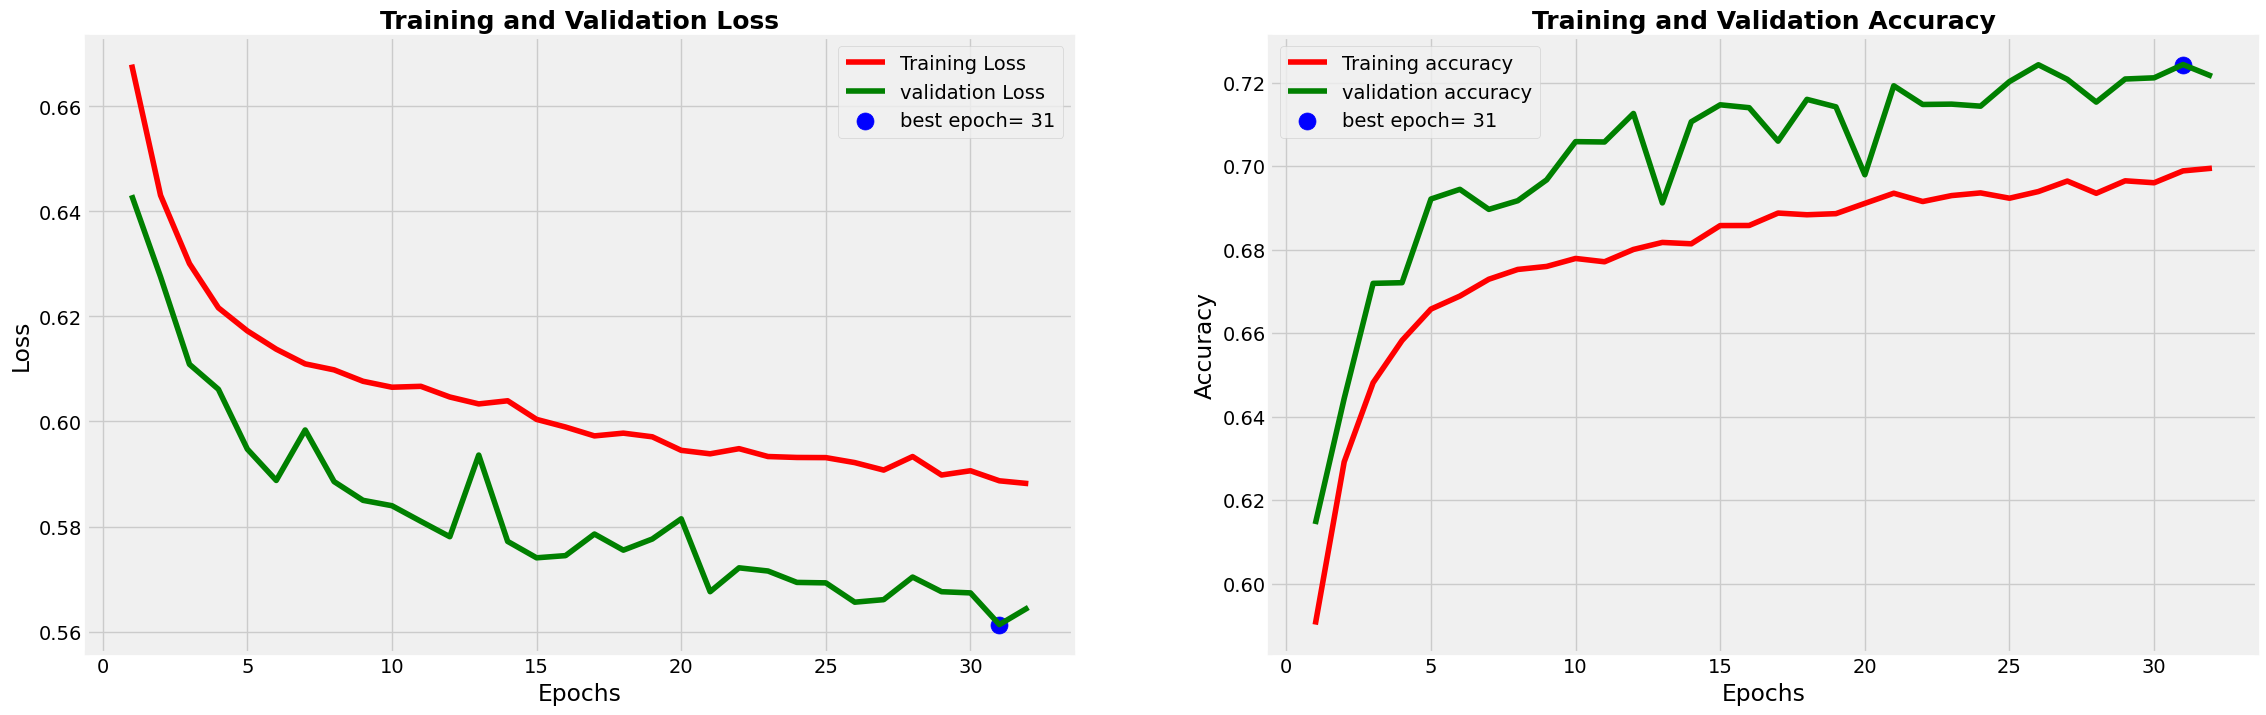

In [20]:
tr_acc   = history.history['accuracy']
tr_loss  = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

idx_loss   = np.argmin(val_loss)
val_lowest = val_loss[idx_loss]
idx_acc    = np.argmax(val_acc)
val_highest= val_acc[idx_acc]

Epochs =[i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(idx_loss + 1)}'
acc_label = f'best epoch= {str(idx_acc + 1)}'

plt.figure(figsize=(28,8))
plt.style.use("fivethirtyeight")

plt.subplot(1,2,1)
plt.plot(Epochs,tr_loss,'r',label='Training Loss')
plt.plot(Epochs,val_loss,'g',label='validation Loss')
plt.scatter(idx_loss+1,val_lowest,s=150,c='blue',label= loss_label)
plt.title('Training and Validation Loss',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs,tr_acc,'r',label='Training accuracy')
plt.plot(Epochs,val_acc,'g',label='validation accuracy')
plt.scatter(idx_acc+1,val_highest,s=150,c='blue',label= acc_label)
plt.title('Training and Validation Accuracy',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math
# 1. Predict probabilities
y_pred_prob = model.predict(
    validation_generator,
    
    steps=math.ceil(validation_generator.samples / validation_generator.batch_size),
    verbose=1
)

# 2. Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 3. True labels
y_test = validation_generator.classes

769/769 [==============================] - 79s 101ms/step


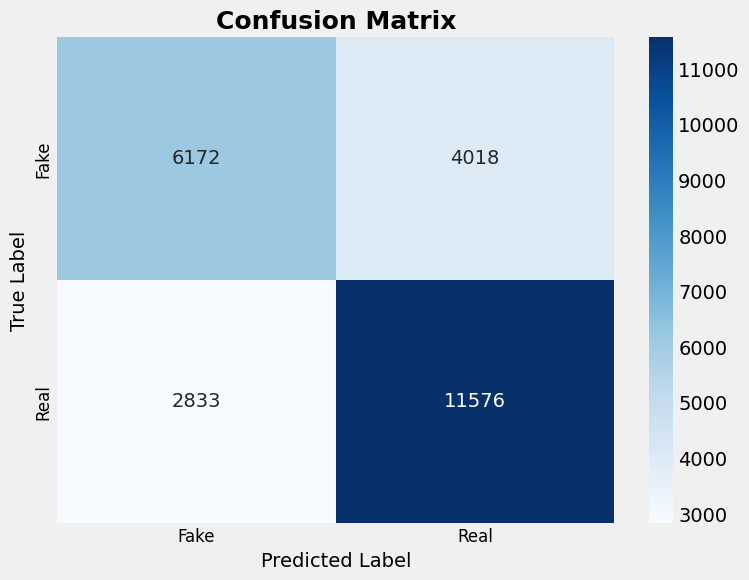

In [22]:
import seaborn as sns 
con = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
class_names = ['Fake', 'Real']

sns.heatmap(
    con,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> # ***Fine Tunning*** 

In [23]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# # Learning rate reduction when val_accuracy plateaus
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     patience=8,
#     verbose=1,
#     factor=0.3,
#     min_lr=1e-6
# )

#  Stop early if validation loss doesn’t improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#  Save the best model (highest val_accuracy)
model_ckpt = ModelCheckpoint(
    "best_pretrained_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

#  Callbacks list
#callbacks = [learning_rate_reduction, early_stop, model_ckpt]
callbacks = [early_stop,model_ckpt]
#  Fit the model using X_train, y_train instead of generator
epochs = 32
history = model.fit(data_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=50,       # You can adjust this
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=1
                   )

Epoch 1/32
3075/3075 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.7196 - auc: 0.7753
Epoch 1: val_accuracy improved from -inf to 0.74044, saving model to best_pretrained_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3075/3075 [==============================] - 515s 164ms/step - loss: 0.6310 - accuracy: 0.7196 - auc: 0.7753 - val_loss: 0.5117 - val_accuracy: 0.7404 - val_auc: 0.8514
Epoch 2/32
3075/3075 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.7777 - auc: 0.8427
Epoch 2: val_accuracy improved from 0.74044 to 0.81788, saving model to best_pretrained_model.h5
3075/3075 [==============================] - 515s 168ms/step - loss: 0.4811 - accuracy: 0.7777 - auc: 0.8427 - val_loss: 0.4278 - val_accuracy: 0.8179 - val_auc: 0.8855
Epoch 3/32
3075/3075 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8029 - auc: 0.8700
Epoch 3: val_accuracy did not improve from 0.81788
3075/3075 [==============================] - 502s 163ms/step - loss: 0.4388 - accuracy: 0.8029 - auc: 0.8700 - val_loss: 0.5522 - val_accuracy: 0.7275 - val_auc: 0.8986
Epoch 4/32
3075/3075 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8198 - auc: 0.8877
Epoch 4: 

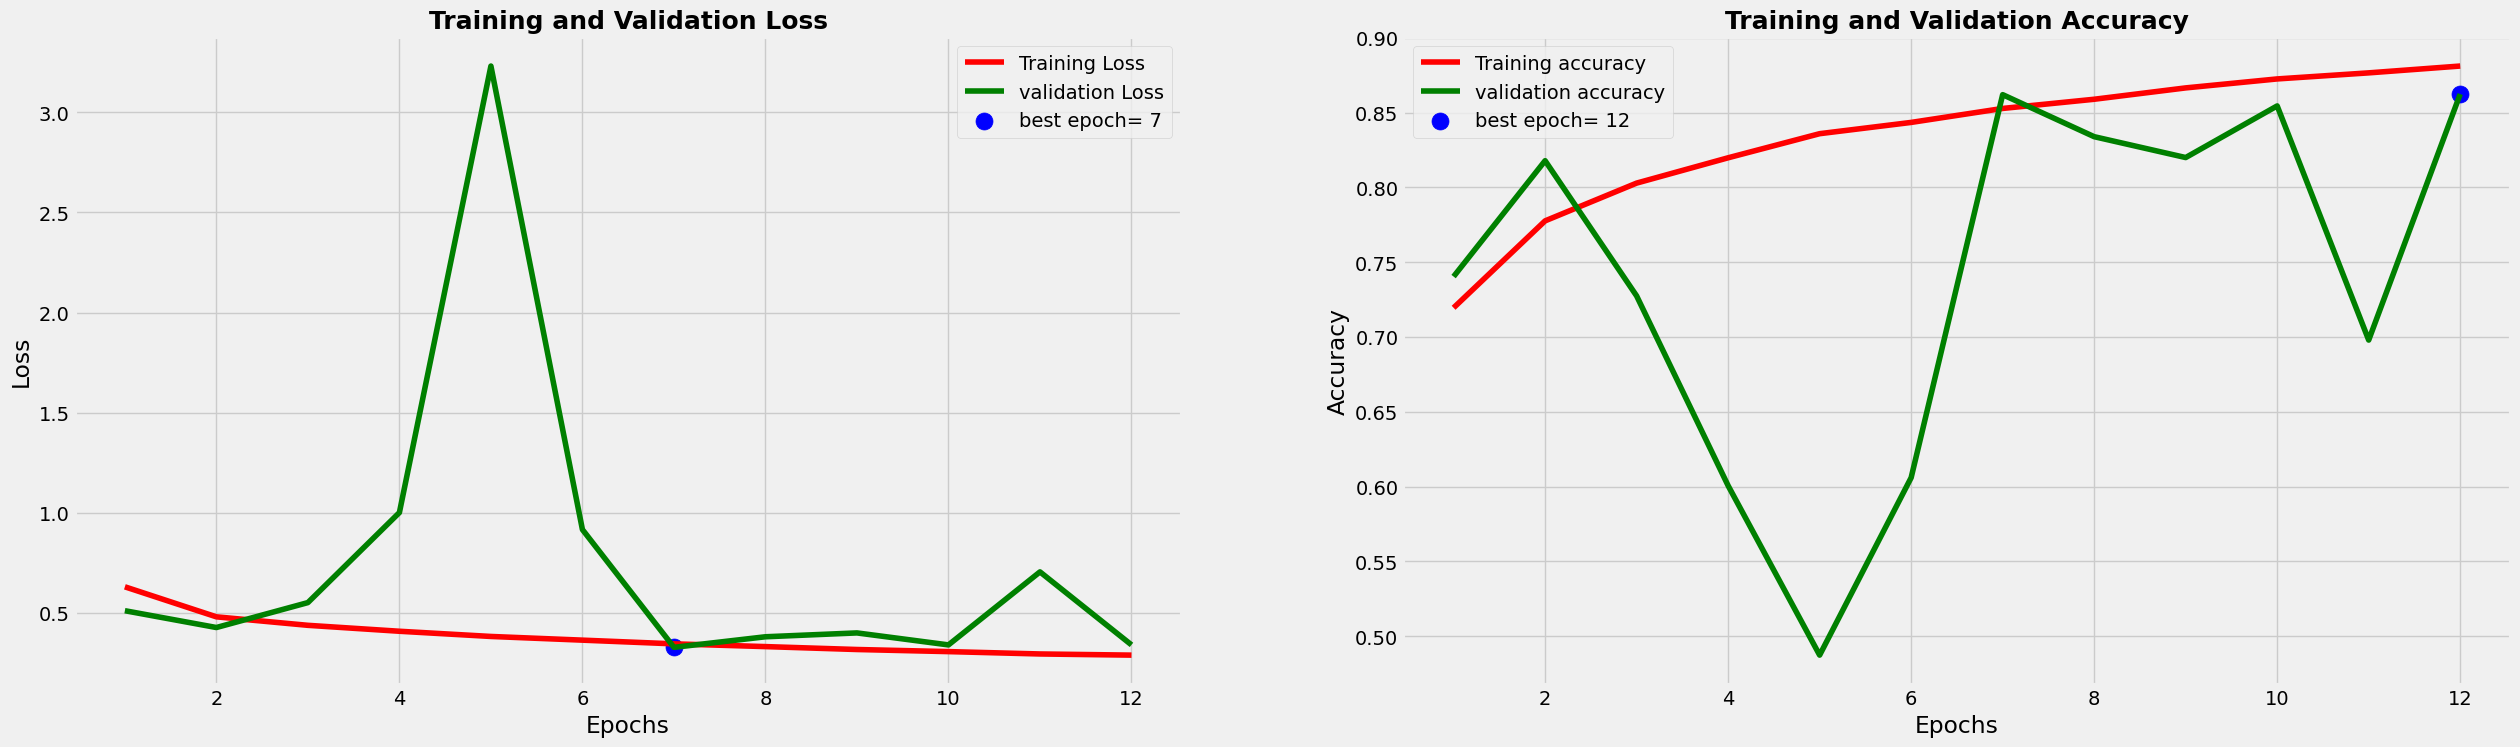

In [26]:
tr_acc   = history.history['accuracy']
tr_loss  = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

idx_loss   = np.argmin(val_loss)
val_lowest = val_loss[idx_loss]
idx_acc    = np.argmax(val_acc)
val_highest= val_acc[idx_acc]

Epochs =[i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(idx_loss + 1)}'
acc_label = f'best epoch= {str(idx_acc + 1)}'

plt.figure(figsize=(28,8))
plt.style.use("fivethirtyeight")

plt.subplot(1,2,1)
plt.plot(Epochs,tr_loss,'r',label='Training Loss')
plt.plot(Epochs,val_loss,'g',label='validation Loss')
plt.scatter(idx_loss+1,val_lowest,s=150,c='blue',label= loss_label)
plt.title('Training and Validation Loss',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs,tr_acc,'r',label='Training accuracy')
plt.plot(Epochs,val_acc,'g',label='validation accuracy')
plt.scatter(idx_acc+1,val_highest,s=150,c='blue',label= acc_label)
plt.title('Training and Validation Accuracy',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math
# 1. Predict probabilities
y_pred_prob = model.predict(
    validation_generator,
    
    steps=math.ceil(validation_generator.samples / validation_generator.batch_size),
    verbose=1
)

# 2. Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 3. True labels
y_test = validation_generator.classes

769/769 [==============================] - 80s 103ms/step


In [28]:
validation_generator.class_indices

{'Fake': 0, 'Real': 1}

In [29]:
np.unique(y_test)

array([0, 1])

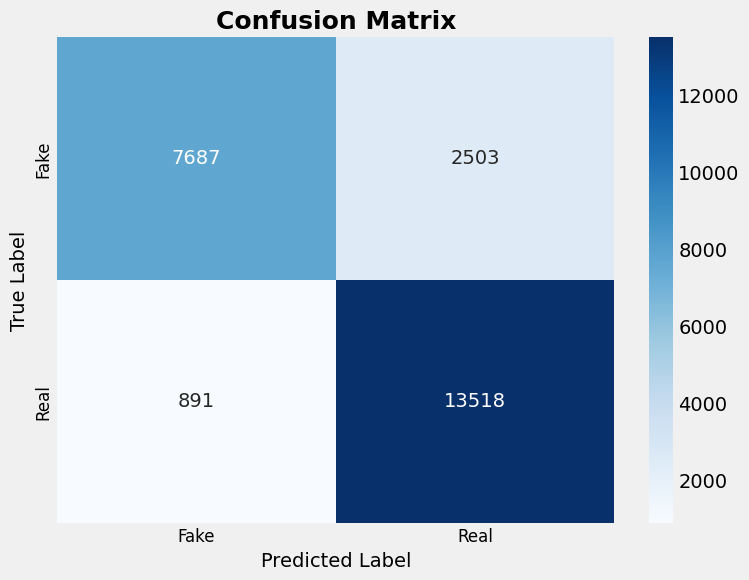

In [30]:
import seaborn as sns 
con = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
class_names = ['Fake', 'Real']

sns.heatmap(
    con,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [31]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

Accuracy Score: 0.8620


In [32]:
for layer in base_model.layers:
    layer.trainable = True

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# # Learning rate reduction when val_accuracy plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

#  Stop early if validation loss doesn’t improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#  Save the best model (highest val_accuracy)
model_ckpt = ModelCheckpoint(
    "best_pretrained_model2.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

#  Callbacks list
callbacks = [learning_rate_reduction, early_stop, model_ckpt]
#callbacks = [early_stop,model_ckpt]

epochs = 32
history = model.fit(data_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=50,       
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=1
                   )

Epoch 1/32
3075/3075 [==============================] - ETA: 0s - loss: 0.8670 - accuracy: 0.8439 - auc: 0.9014
Epoch 1: val_accuracy improved from -inf to 0.93914, saving model to best_pretrained_model2.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3075/3075 [==============================] - 1152s 364ms/step - loss: 0.8670 - accuracy: 0.8439 - auc: 0.9014 - val_loss: 0.1641 - val_accuracy: 0.9391 - val_auc: 0.9817 - lr: 1.0000e-05
Epoch 2/32
3075/3075 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9466 - auc: 0.9852
Epoch 2: val_accuracy improved from 0.93914 to 0.94223, saving model to best_pretrained_model2.h5
3075/3075 [==============================] - 1116s 363ms/step - loss: 0.1442 - accuracy: 0.9466 - auc: 0.9852 - val_loss: 0.1477 - val_accuracy: 0.9422 - val_auc: 0.9909 - lr: 1.0000e-05
Epoch 3/32
3075/3075 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9736 - auc: 0.9957
Epoch 3: val_accuracy improved from 0.94223 to 0.97626, saving model to best_pretrained_model2.h5
3075/3075 [==============================] - 1117s 363ms/step - loss: 0.0730 - accuracy: 0.9736 - auc: 0.9957 - val_loss: 0.0735 - val_accuracy: 0.9763 - val_auc: 0.9950 - lr: 1.0000e-05
Epoch 4/32
3075/307

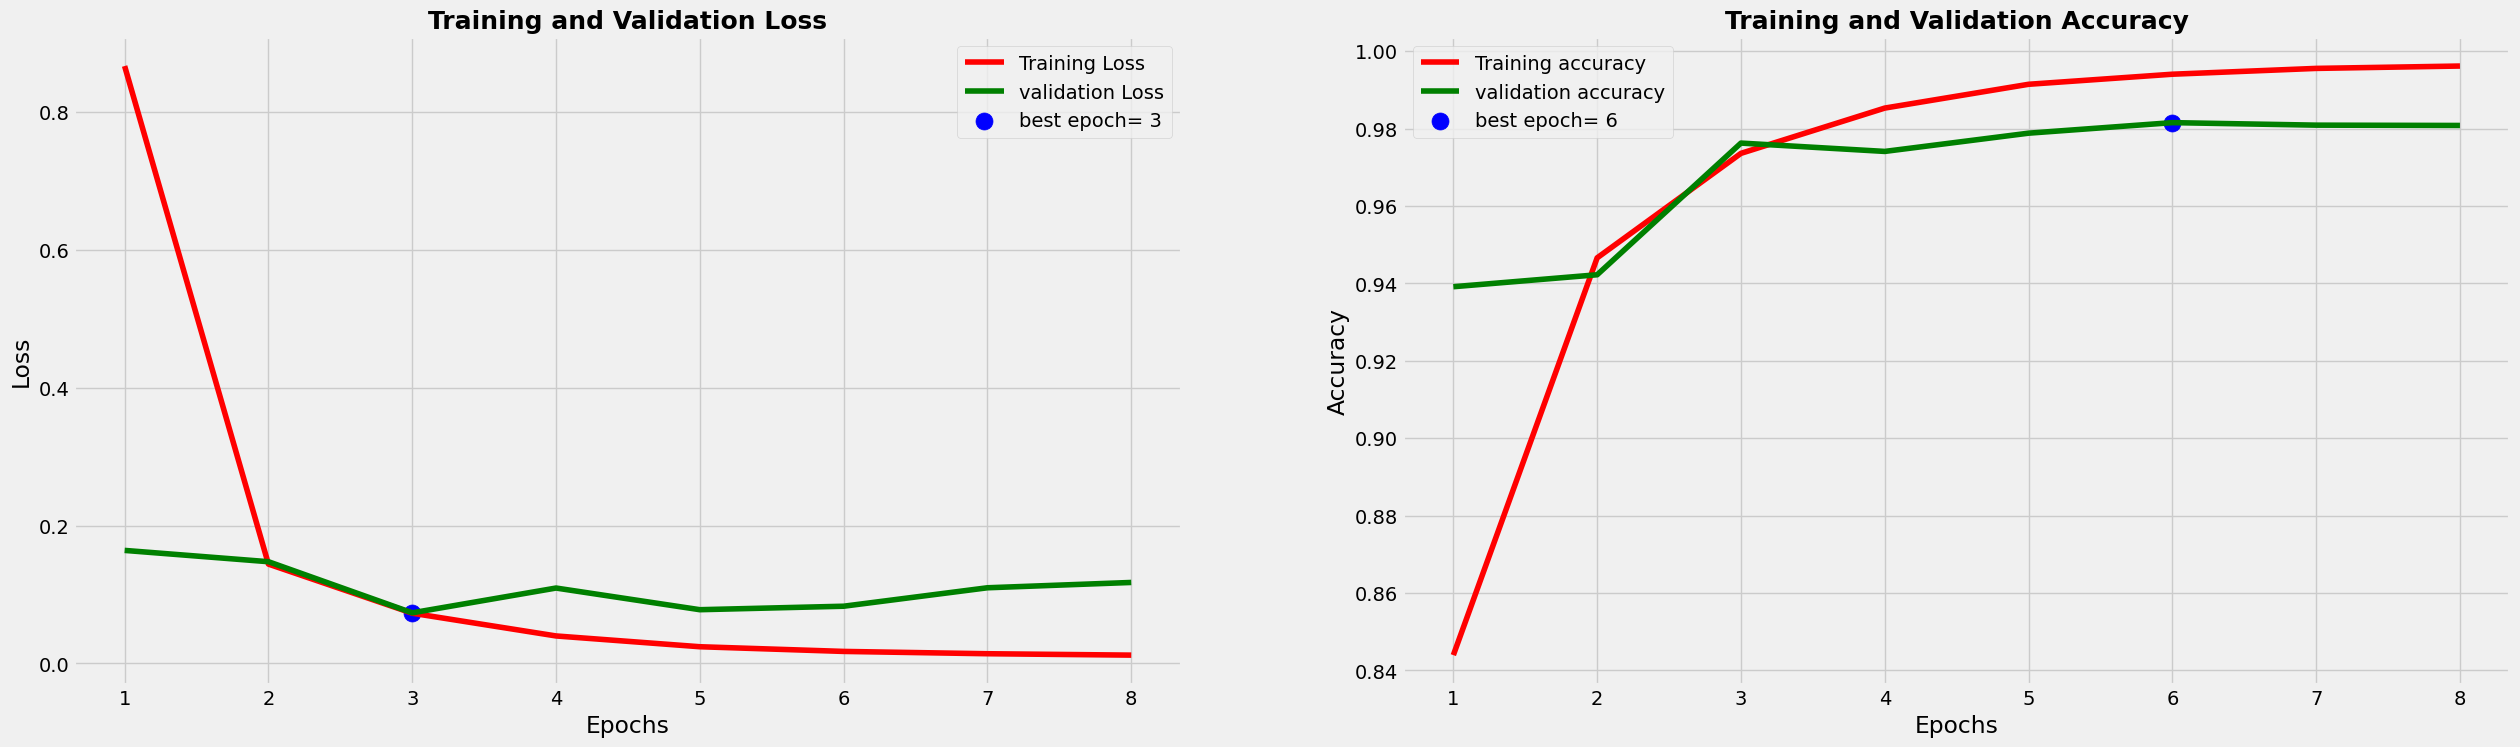

In [35]:
tr_acc   = history.history['accuracy']
tr_loss  = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

idx_loss   = np.argmin(val_loss)
val_lowest = val_loss[idx_loss]
idx_acc    = np.argmax(val_acc)
val_highest= val_acc[idx_acc]

Epochs =[i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(idx_loss + 1)}'
acc_label = f'best epoch= {str(idx_acc + 1)}'

plt.figure(figsize=(28,8))
plt.style.use("fivethirtyeight")

plt.subplot(1,2,1)
plt.plot(Epochs,tr_loss,'r',label='Training Loss')
plt.plot(Epochs,val_loss,'g',label='validation Loss')
plt.scatter(idx_loss+1,val_lowest,s=150,c='blue',label= loss_label)
plt.title('Training and Validation Loss',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs,tr_acc,'r',label='Training accuracy')
plt.plot(Epochs,val_acc,'g',label='validation accuracy')
plt.scatter(idx_acc+1,val_highest,s=150,c='blue',label= acc_label)
plt.title('Training and Validation Accuracy',fontweight='bold',fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math
# 1. Predict probabilities
y_pred_prob = model.predict(
    validation_generator,
    
    steps=math.ceil(validation_generator.samples / validation_generator.batch_size),
    verbose=1
)

# 2. Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 3. True labels
y_test = validation_generator.classes

769/769 [==============================] - 79s 102ms/step


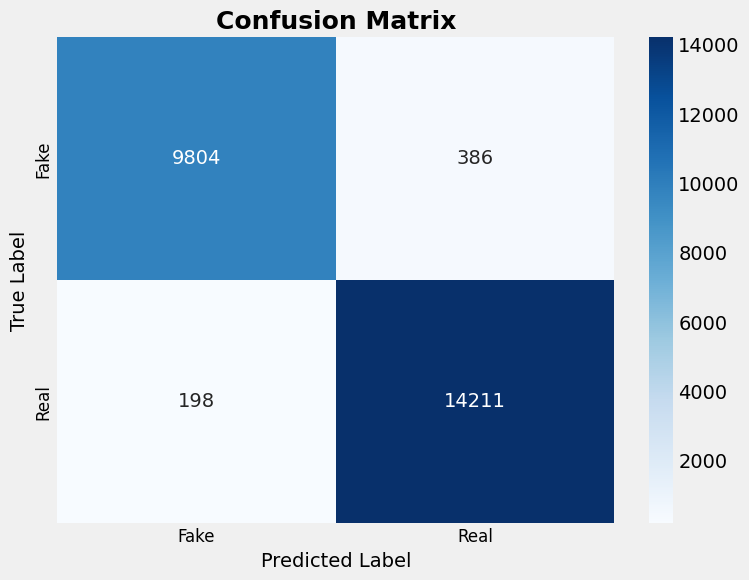

🔍 Classification Report:

              precision    recall  f1-score   support

        Fake       0.98      0.96      0.97     10190
        Real       0.97      0.99      0.98     14409

    accuracy                           0.98     24599
   macro avg       0.98      0.97      0.98     24599
weighted avg       0.98      0.98      0.98     24599

✅ Accuracy Score: 0.9763


In [37]:
import seaborn as sns 
con = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
class_names = ['Fake', 'Real']

sns.heatmap(
    con,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# 5. Print classification metrics
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# 6. Print accuracy
print(f"✅ Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
